<a href="https://colab.research.google.com/github/KoreTane/MKTBank/blob/main/MKTBank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install pyspark


# Exploratory Analysis

## Customer Profile
###The profile of our customer is as follows:
* Age Range: Adults in their 40s.
* Marital Status: Predominantly married, with children (which aligns with the average number of children per couple in Europe).
* Profession: Most customers work in administrative, operational, and technical fields.
* Social Class: Customers belong to classes B and C.
* Financial Behavior: They are considered good payers.
Half have a home loan. A small portion has personal credit.

## Technical Profile of Contacts
###The characteristics of the contacts are as follows:
* Contact Method: The majority of interactions are conducted via mobile phone.
* Contact Frequency: Contacts occur more frequently at the end of the year and during the last days of the month, especially starting from the 20th.
* Call Duration: The average duration of calls is between 6 to 7 minutes.
More than half of the calls do not reach this duration, suggesting that many contacts are made with uninterested individuals or those already predisposed to adopting the product.
* Sales Effectiveness: Typically, sales are finalized within three contacts, and half of the customers end up purchasing the product.



In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import col, count, when
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession.builder.appName("BankMarketing").getOrCreate()
df = spark.read.csv("bank.csv", header=True, inferSchema=True)
# Criar um ID único para cada cliente
df = df.withColumn("client_id", monotonically_increasing_id())

colunas = ['client_id'] + [col for col in df.columns if col != 'client_id']
df = df.select(colunas)

df.show(50)

df.printSchema()

df.summary().show()

+---------+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|client_id|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---------+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|        0| 59|      admin.| married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|
|        1| 56|      admin.| married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|
|        2| 41|  technician| married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|
|        3| 55|    services| married|secondary|     no|   2476|    yes|  no|unknown|  5|  may|     579|       1|   -1|       0| un

In [3]:
# Criar um ID único para cada cliente
df = df.withColumn("client_id", monotonically_increasing_id())

df.show(5)


+---------+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|client_id|age|       job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---------+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|        0| 59|    admin.|married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|
|        1| 56|    admin.|married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|
|        2| 41|technician|married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|
|        3| 55|  services|married|secondary|     no|   2476|    yes|  no|unknown|  5|  may|     579|       1|   -1|       0| unknown|    yes|
|     

In [4]:
total_count = df.count()

distinct_count = df.distinct().count()

# Verificar se há duplicatas
if total_count > distinct_count:
    print("Existem dados duplicados no DataFrame.")
else:
    print("Não existem dados duplicados no DataFrame.")

Não existem dados duplicados no DataFrame.


In [5]:
# Análises Simples
# 1. age: Contar quantas IDs têm mais de 80 anos
age_above_80 = df.filter(df.age > 80).count()

# 2. Contando IDs agrupados por job e calculando a média do balance
job_count = df.groupBy("job") \
               .agg(
                   F.count("*").alias("count"),  # Contagem de IDs
                   F.format_number(F.avg("balance"), 2).alias("average_balance")  # Média do balance formatada
               ) \
               .sort(F.col("count").desc())

# 3. marital: Contar IDs agrupados por estado civil
marital_count = df.groupBy("marital").count().sort(col("count").desc())

# 4. Contando IDs agrupados por nível de escolaridade e calculando a média do balance
education_count = df.groupBy("education") \
                     .agg(
                         F.count("*").alias("count"),  # Contagem de IDs
                         F.format_number(F.avg("balance"), 2).alias("average_balance")  # Média do balance formatada
                     ) \
                     .sort(F.col("count").desc())

# 5. default: Contar IDs com e sem crédito em atraso
default_count = df.groupBy("default").count().sort(col("count").desc())

# 6. balance: Contar quantas IDs estão com balance negativo e positivo
balance_count = df.groupBy(F.when(df.balance < 0, "Negativo").otherwise("Positivo").alias("Balance")).count()

# 7. housing: Contar quantos IDs possuem housing e quantos não
housing_count = df.groupBy("housing").count().sort(col("count").desc())

# 8. loan: Contar quantos IDs possuem loan e quantos não
loan_count = df.groupBy("loan").count().sort(col("count").desc())

# 9. contact: Contagem do número de IDs agrupada por contact
contact_count = df.groupBy("contact").count().sort(col("count").desc())

# 10. day: Contar a distribuição de contatos por dia do mês
day_count = df.groupBy("day").count().sort(col("count").desc())

# 11. month: Contar a distribuição de contatos por mês
month_count = df.groupBy("month").count().sort(col("count").desc())

# 12. duration: Contar quantas IDs têm duração de contato acima e abaixo da média
average_duration = df.select(F.avg("duration")).first()[0]
duration_count = df.groupBy(F.when(df.duration < average_duration, "Abaixo da Média").otherwise("Acima da Média").alias("Duração")).count().sort(col("count").desc())

# 13. campaign: Distribuição de contatos feitos durante a campanha
campaign_count = df.groupBy("campaign").count().sort(col("count").desc())

# 14. pdays: Distribuição do número de dias desde o último contato (999 significa que nunca foi contatado)
pdays_count = df.groupBy(F.when(df.pdays == 999, "Nunca contatado").otherwise(df.pdays)).count().sort(col("count").desc())

# 15. previous: Distribuição do número de contatos anteriores
previous_count = df.groupBy("previous").count().sort(col("count").desc())

# 16. poutcome: Contar resultados da campanha anterior
poutcome_count = df.groupBy("poutcome").count().sort(col("count").desc())

# 17. deposit: Contagem de aceitação da oferta (sim/não)
deposit_count = df.groupBy("deposit").count()

# Exibindo os resultados em uma matriz

print("Análise Completa de Clientes:")

print(f"\n1. IDs com mais de 80 anos: {age_above_80}")

print("\n2. Contagem de IDs agrupados por Job:")
job_count.show()

print("\n3. Contagem de IDs agrupados por Estado Civil:")
marital_count.show()

print("\n4. Contagem de IDs agrupados por Nível de Escolaridade:")
education_count.show()

print("\n5. Contagem de IDs com e sem Crédito em Atraso:")
default_count.show()

print("\n6. Contagem de IDs com Balance Negativo e Positivo:")
balance_count.show()

print("\n7. Contagem de IDs com Housing:")
housing_count.show()

print("\n8. Contagem de IDs com Loan:")
loan_count.show()

print("\n9. Contagem de IDs agrupados por Contact:")
contact_count.show()

print("\n10. Distribuição de contatos por Dia do Mês:")
day_count.show()

print("\n11. Distribuição de contatos por Mês:")
month_count.show()

print("\n12. A média é: 371 segundos. Duração do contato (Abaixo/Acima da Média):")
duration_count.show()

print("\n13. Distribuição de contatos feitos durante a Campanha:")
campaign_count.show()

print("\n14. Distribuição do Número de Dias desde o Último Contato:")
pdays_count.show()

print("\n15. Distribuição do Número de Contatos Anteriores:")
previous_count.show()

print("\n16. Resultados da Campanha Anterior:")
poutcome_count.show()

print("\n17. Aceitação da Oferta (Sim/Não):")
deposit_count.show()

Análise Completa de Clientes:

1. IDs com mais de 80 anos: 55

2. Contagem de IDs agrupados por Job:
+-------------+-----+---------------+
|          job|count|average_balance|
+-------------+-----+---------------+
|   management| 2566|       1,793.66|
|  blue-collar| 1944|       1,203.93|
|   technician| 1823|       1,556.29|
|       admin.| 1334|       1,195.87|
|     services|  923|       1,081.17|
|      retired|  778|       2,417.25|
|self-employed|  405|       1,865.37|
|      student|  360|       1,500.78|
|   unemployed|  357|       1,314.72|
| entrepreneur|  328|       1,621.94|
|    housemaid|  274|       1,366.16|
|      unknown|   70|       1,945.46|
+-------------+-----+---------------+


3. Contagem de IDs agrupados por Estado Civil:
+--------+-----+
| marital|count|
+--------+-----+
| married| 6351|
|  single| 3518|
|divorced| 1293|
+--------+-----+


4. Contagem de IDs agrupados por Nível de Escolaridade:
+---------+-----+---------------+
|education|count|average_balanc

In [6]:
# Excluir as linhas onde age > 80 ou balance > 10000
df = df.filter(
    (df.age <= 80) &
    (df.balance <= 10000) &
    (df.balance >= -2000) &
    (df.job != "unknown") &
    (df.education != "unknown")
)

# Substituir "unknown" por "não informado" nas colunas contact e poutcome
df = df.withColumn("contact", F.when(df.contact == "unknown", "não informado").otherwise(df.contact)) \
       .withColumn("poutcome", F.when(df.poutcome == "unknown", "não informado").otherwise(df.poutcome))

# Exibir o DataFrame resultante
df.show()


+---------+---+-----------+--------+---------+-------+-------+-------+----+-------------+---+-----+--------+--------+-----+--------+-------------+-------+
|client_id|age|        job| marital|education|default|balance|housing|loan|      contact|day|month|duration|campaign|pdays|previous|     poutcome|deposit|
+---------+---+-----------+--------+---------+-------+-------+-------+----+-------------+---+-----+--------+--------+-----+--------+-------------+-------+
|        0| 59|     admin.| married|secondary|     no|   2343|    yes|  no|não informado|  5|  may|    1042|       1|   -1|       0|não informado|    yes|
|        1| 56|     admin.| married|secondary|     no|     45|     no|  no|não informado|  5|  may|    1467|       1|   -1|       0|não informado|    yes|
|        2| 41| technician| married|secondary|     no|   1270|    yes|  no|não informado|  5|  may|    1389|       1|   -1|       0|não informado|    yes|
|        3| 55|   services| married|secondary|     no|   2476|    yes|

In [7]:
df.summary().show()

+-------+------------------+------------------+----------+--------+---------+-------+------------------+-------+-----+---------+------------------+-----+------------------+------------------+------------------+------------------+--------+-------+
|summary|         client_id|               age|       job| marital|education|default|           balance|housing| loan|  contact|               day|month|          duration|          campaign|             pdays|          previous|poutcome|deposit|
+-------+------------------+------------------+----------+--------+---------+-------+------------------+-------+-----+---------+------------------+-----+------------------+------------------+------------------+------------------+--------+-------+
|  count|             10369|             10369|     10369|   10369|    10369|  10369|             10369|  10369|10369|    10369|             10369|10369|             10369|             10369|             10369|             10369|   10369|  10369|
|   mean|  5

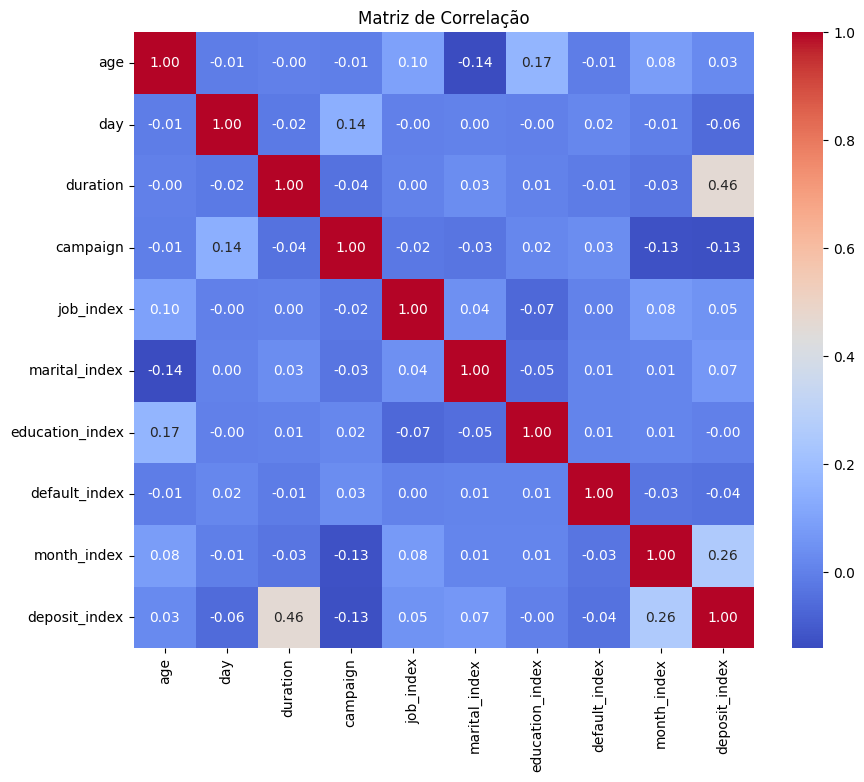

In [8]:
# Variáveis categóricas a serem transformadas
categorical_cols = ['job', 'marital', 'education', 'default', 'month', 'deposit']

# Criar indexadores para cada variável categórica
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in categorical_cols]

# Criar pipeline para aplicar as transformações
pipeline = Pipeline(stages=indexers)
df_indexed = pipeline.fit(df).transform(df)

# Selecionar variáveis numéricas e indexadas para correlação
numeric_cols = ['age', 'day', 'duration', 'campaign'] + [col+"_index" for col in categorical_cols]
df_numeric = df_indexed.select(numeric_cols)

# Convertendo para Pandas para calcular a correlação
df_pandas = df_numeric.toPandas()

# Calculando a matriz de correlação
correlation_matrix = df_pandas.corr()

# Criando a matriz de correlação colorida
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()


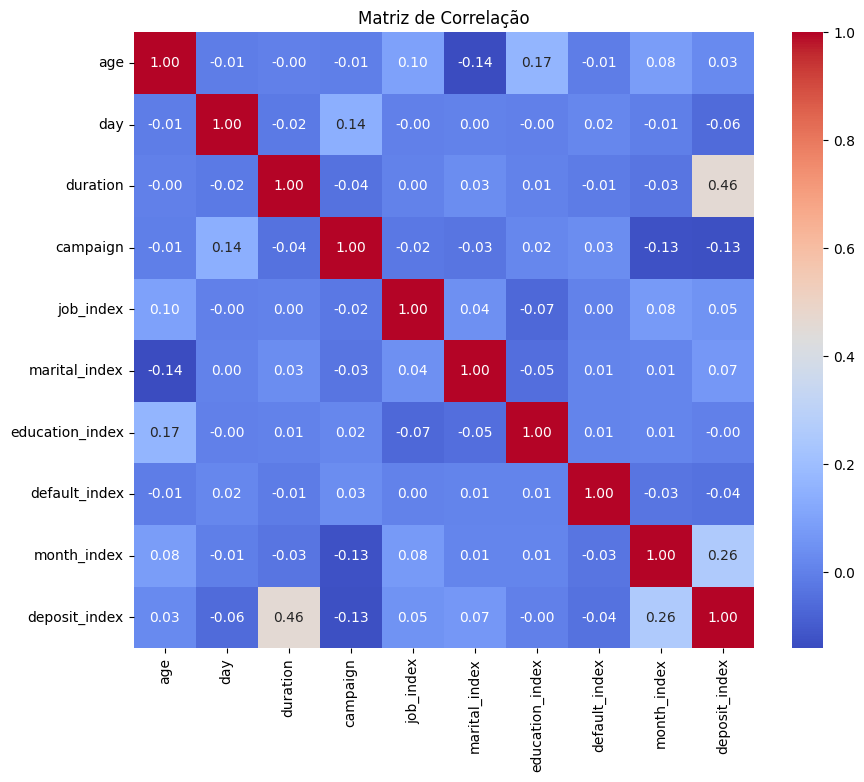

In [9]:
# Convertendo para Pandas para calcular a correlação
df_pandas = df_numeric.toPandas()

# Calculando a matriz de correlação
correlation_matrix = df_pandas.corr()

# Criando a matriz de correlação colorida
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()